In [ ]:
import os
data  = []
hyp_N = 2
root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt'
with open(root_dir) as f:
    lines = f.readlines()
    

    for line in lines:
        data.append(line.split()[0])
        

all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]

In [ ]:
import pickle
index = 10
scene = 200
# TODO ; add assert to return hyp-N boxes per image
scene_path = all_files[scene]
data = pickle.load(open(scene_path, "rb"))

In [ ]:

import collections, os, io
from PIL import Image
import torch
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset
import random
import pickle
import core.utils_data as utils_disco
import core.utils_vox as utils_vox
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# images = torch.as_tensor(data['rgb_camXs_raw']).permute(0,3,1,2)/255.
# _, _, H_orig, W_orig = images.shape
# query_image, key_image = images[0,:3,:,:], images[1,:3,:,:]

In [ ]:
# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(query_image.permute(1,2,0))
# axarr[1].imshow(key_image.permute(1,2,0))

In [ ]:
hyp_B = 1
hyp_S = 2

__p = lambda x: utils_disco.pack_seqdim(x, hyp_B)
__u = lambda x: utils_disco.unpack_seqdim(x, hyp_B)
__pb = lambda x: utils_disco.pack_boxdim(x, hyp_N)
__ub = lambda x: utils_disco.unpack_boxdim(x, hyp_N)

In [ ]:
Z, Y, X = 144, 144, 144
Z2, Y2, X2 = int(Z/2), int(Y/2), int(X/2)
Z4, Y4, X4 = int(Z/4), int(Y/4), int(X/4)

In [ ]:
pix_T_cams = torch.from_numpy(data["pix_T_cams_raw"][index:index+2]).reshape(hyp_B, hyp_S, 4, 4).cuda()

In [ ]:
np.stack((data["pix_T_cams_raw"][index],data["pix_T_cams_raw"][index+5])).shape

(2, 4, 4)

In [ ]:
camRs_T_origin = data['camR_T_origin_raw'][index:index+2]
camRs_T_origin = torch.from_numpy(camRs_T_origin).reshape(hyp_B, hyp_S, 4, 4).cuda()
camRs_T_origin.shape

torch.Size([1, 2, 4, 4])

In [ ]:
camRs_T_origin.squeeze().shape

torch.Size([2, 4, 4])

In [ ]:
rgb_camXs = data["rgb_camXs_raw"]

In [ ]:
origin_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_origin)))

In [ ]:
origin_T_camXs = torch.from_numpy(data['origin_T_camXs_raw'][index:index+2])
origin_T_camXs = origin_T_camXs.reshape(hyp_B, hyp_S, 4, 4).cuda()

In [ ]:
camX0_T_camXs = utils_disco.get_camM_T_camXs(origin_T_camXs, ind=0)
camRs_T_camXs = __u(torch.matmul(utils_disco.safe_inverse(__p(origin_T_camRs)), __p(origin_T_camXs)))

In [ ]:
camXs_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_camXs)))
camX0_T_camRs = camXs_T_camRs[:,0]
camX1_T_camRs = camXs_T_camRs[:,1]

In [ ]:
camR_T_camX0  = utils_disco.safe_inverse(camX0_T_camRs)

In [ ]:
tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
tree_path = tree_path.replace("datasets","dataset")
tree_file = pickle.load(open(os.path.join(tree_path),"rb"))

In [ ]:
N = hyp_N
do_shape = True
do_color = False
do_material = False
do_style = False
do_style_content = False

def trees_rearrange(trees):
    updated_trees =[]
    all_bboxes = []
    all_scores = []
    all_classes_list = []
    for tree in trees:
        tree,boxes,_,all_classes = bbox_rearrange(tree,boxes=[],classes={},all_classes=[])
        if do_shape:
            classes = [class_val["shape"] for class_val  in all_classes]
        elif do_color:
            classes = [class_val["color"] for class_val  in all_classes]
        elif do_material:
            classes = [class_val["material"] for class_val  in all_classes]
        elif do_style:
            classes = [class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
        elif do_style_content:
            classes = [class_val["shape"]+"/"+class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
        elif do_color_content:            
            classes = [class_val["shape"]+"/"+class_val["color"] for class_val  in all_classes]
        elif do_material_content:            
            classes = [class_val["shape"]+"/"+ class_val["material"] for class_val  in all_classes]
        else:            
            classes = [class_val["shape"]+"/"+ class_val["color"] +"_"+class_val["material"] for class_val  in all_classes]
        boxes = np.stack(boxes)
        classes = np.stack(classes)
        n,_  = boxes.shape 
        assert n == len(classes)
        scores = np.pad(np.ones([n]),[0,N-n])
        boxes = np.pad(boxes,[[0,N-n],[0,0]])
        classes = np.pad(classes,[0,N-n])
        updated_trees.append(tree)
        all_classes_list.append(classes)
        all_scores.append(scores)
        all_bboxes.append(boxes)
    all_bboxes = np.stack(all_bboxes)
    all_scores = np.stack(all_scores)
    all_classes_list = np.stack(all_classes_list)
    return all_bboxes,all_scores,all_classes_list

def bbox_rearrange(tree,boxes= [],classes={},all_classes=[]):
    for i in range(0, tree.num_children):
        updated_tree,boxes,classes,all_classes = bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
        tree.children[i] = updated_tree     
    if tree.function == "describe":
        xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
        box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
        tree.bbox_origin = box
        boxes.append(box)
        classes["shape"] = tree.word
        all_classes.append(classes)
        classes = {}
    if tree.function == "combine":
        if "large" in tree.word or "small" in tree.word:
            classes["size"] = tree.word
        elif "metal" in tree.word or "rubber" in tree.word:
            classes["material"] = tree.word
        else:
            classes["color"] = tree.word
    return tree,boxes,classes,all_classes

In [ ]:
gt_boxesR,scores,classes = trees_rearrange([tree_file])

In [ ]:
gt_boxesR = torch.from_numpy(gt_boxesR).cuda().float() # torch.Size([2, 3, 6])
gt_boxesR_end = torch.reshape(gt_boxesR,[hyp_B,hyp_N,2,3])
gt_boxesR_theta = utils_disco.get_alignedboxes2thetaformat(gt_boxesR_end)
gt_boxesR_corners = utils_disco.transform_boxes_to_corners(gt_boxesR_theta)

/home/mprabhud/ishita/non-metric_3d_representation/core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [ ]:
gt_boxesR.shape

torch.Size([1, 2, 6])

In [ ]:
gt_boxesRMem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z2,Y2,X2))
gt_boxesRMem_end = utils_disco.get_ends_of_corner(gt_boxesRMem_corners)

In [ ]:
gt_boxesRMem_theta = utils_disco.transform_corners_to_boxes(gt_boxesRMem_corners)
gt_boxesRUnp_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z,Y,X))

In [ ]:
gt_boxesRUnp_end = utils_disco.get_ends_of_corner(gt_boxesRUnp_corners)

In [ ]:
gt_boxesX0_corners = __ub(utils_disco.apply_4x4(camX0_T_camRs, __pb(gt_boxesR_corners)))
gt_boxesX1_corners = __ub(utils_disco.apply_4x4(camX1_T_camRs, __pb(gt_boxesR_corners)))

In [ ]:
gt_boxesX0_corners.shape

torch.Size([1, 2, 8, 3])

In [ ]:
pix_T_cams.shape

torch.Size([1, 2, 4, 4])

In [ ]:
gt_boxesXs_corners = __u(__ub(utils_disco.apply_4x4(__p(camXs_T_camRs), __p(__pb(gt_boxesR_corners).unsqueeze(1).repeat(1,hyp_S,1,1)) )))
gt_boxesXs_end = __u(utils_disco.get_ends_of_corner(__p(gt_boxesXs_corners)))

In [ ]:
gt_boxesX0Mem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesX0_corners),Z2,Y2,X2))
gt_boxesX0Mem_theta = utils_disco.transform_corners_to_boxes(gt_boxesX0Mem_corners)
gt_boxesX0Mem_end = utils_disco.get_ends_of_corner(gt_boxesX0Mem_corners)
gt_boxesX0_end = utils_disco.get_ends_of_corner(gt_boxesX0_corners)

In [ ]:
gt_cornersX0_pix = __ub(utils_disco.apply_pix_T_cam(pix_T_cams[:,0], __pb(gt_boxesX0_corners)))
gt_cornersX1_pix = __ub(utils_disco.apply_pix_T_cam(pix_T_cams[:,1], __pb(gt_boxesX1_corners)))

In [ ]:
gt_cornersX1_pix.shape

torch.Size([1, 2, 8, 2])

In [ ]:
gt_boxesXs_corners.shape

torch.Size([1, 2, 2, 8, 3])

In [ ]:

__pbbs = lambda x: utils_disco.pack_boxbatchviewdim(x,hyp_B, hyp_N)
__ubbs = lambda x: utils_disco.unpack_boxbatchviewdim(x,hyp_B, hyp_N)
__pbbs_box = lambda x: utils_disco.pack_boxbatchviewdim_box(x,hyp_B, hyp_N)

# gt_boxesXs_corners = __pbbs_box(gt_boxesXs_corners)
# gt_cornersXs_pix = __ub(utils_disco.apply_pix_T_cam( __p(pix_T_cams),gt_boxesXs_corners ))

In [ ]:

def flip_image(img):

    #read the image
    im = Image.fromarray(img)

    #flip image
    out = im.transpose(Image.FLIP_LEFT_RIGHT)
    return np.array(out)
                

In [ ]:
rgb_camXs = data["rgb_camXs_raw"][:,:,:,:3]
rgb_camX0 = torch.from_numpy(rgb_camXs[index]).permute(2,0,1).reshape(hyp_B, 3, 256, 256) #torch.from_numpy(np.fliplr(rgb_camXs[0,0])).reshape(1, 256, 256, 3).permute(0,3,1,2)
rgb_camX1 = torch.from_numpy(rgb_camXs[index+1]).permute(2,0,1).reshape(hyp_B, 3, 256, 256)

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import cm
import matplotlib
from itertools import combinations

def draw_corners_on_image(rgb, corners_cam, scores, tids, pix_T_cam,info_text=None):
    # first we need to get rid of invalid gt boxes
    # gt_boxes = trim_gt_boxes(gt_boxes)
    B, C, H, W = list(rgb.shape)
    assert(C==3)
    B2, N, D, E = list(corners_cam.shape)
    assert(B2==B)
    assert(D==8) # 8 corners
    assert(E==3) # 3D

    #rgb = back2color(rgb)
    corners_cam_ = torch.reshape(corners_cam, [B, N*8, 3])
    corners_pix_ = utils_disco.apply_pix_T_cam(pix_T_cam, corners_cam_)
    corners_pix = torch.reshape(corners_pix_, [B, N, 8, 2])
    out = draw_boxes_on_image_py(rgb[0].cpu().numpy(),
                                      corners_pix[0].cpu().numpy(),
                                      scores[0].cpu().numpy(),
                                      tids[0].cpu().numpy(),info_text)
    out = torch.from_numpy(out).type(torch.ByteTensor).permute(2, 0, 1)
    out = torch.unsqueeze(out, dim=0)
    #out = preprocess_color(out)
    out = torch.reshape(out, [1, C, H, W])
    return out, corners_pix

def draw_boxes_on_image_py(rgb, corners_pix, scores, tids,info_text=None, boxes=None, thickness=1,text=False):
    # all inputs are numpy tensors
    # rgb is H x W x 3
    # corners_pix is N x 8 x 2, in xy order
    # scores is N
    # tids is N
    # boxes is N x 9 < this is only here to print some rotation info
    # pix_T_cam is 4 x 4
    rgb = np.transpose(rgb, [1, 2, 0]) # put channels last
    rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    H, W, C = rgb.shape
    assert(C==3)
    N, D, E = corners_pix.shape
    assert(D==8)
    assert(E==2)

    if boxes is not None:
        rx = boxes[:,6]
        ry = boxes[:,7]
        rz = boxes[:,8]
    else:
        rx = 0
        ry = 0
        rz = 0

    color_map = matplotlib.cm.get_cmap('tab20')
    color_map = color_map.colors

    # draw
    for ind, corners in enumerate(corners_pix):
        # corners is 8 x 2
        # st()
        if not np.isclose(scores[ind], 0.0):
            # print 'score = %.2f' % scores[ind]
            color_id = tids[ind] % 20
            color = color_map[2]
            color_text = color_map[2]

            # st()

            color = np.array(color)*255.0
            # print 'tid = %d; score = %.3f' % (tids[ind], scores[ind])
            if info_text is not None:
                text_to_put = info_text[ind]
                cv2.putText(rgb,
                            text_to_put, 
                            (np.min(corners[:,0]), np.min(corners[:,1])),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, # font size
                            color_text,
                            2) # font weight

            for c in corners:

                # rgb[pt1[0], pt1[1], :] = 255
                # rgb[pt2[0], pt2[1], :] = 255
                # rgb[np.clip(int(c[0]), 0, W), int(c[1]), :] = 255

                c0 = np.clip(int(c[0]), 0,  W-1)
                c1 = np.clip(int(c[1]), 0,  H-1)
                rgb[c1, c0, :] = 255

            # we want to distinguish between in-plane edges and out-of-plane ones
            # so let's recall how the corners are ordered:
            xs = np.array([-1/2., -1/2., -1/2., -1/2., 1/2., 1/2., 1/2., 1/2.])
            ys = np.array([-1/2., -1/2., 1/2., 1/2., -1/2., -1/2., 1/2., 1/2.])
            zs = np.array([-1/2., 1/2., -1/2., 1/2., -1/2., 1/2., -1/2., 1/2.])
            xs = np.reshape(xs, [8, 1])
            ys = np.reshape(ys, [8, 1])
            zs = np.reshape(zs, [8, 1])
            offsets = np.concatenate([xs, ys, zs], axis=1)

            corner_inds = list(range(8))
            combos = list(combinations(corner_inds, 2))

            for combo in combos:
                pt1 = offsets[combo[0]]
                pt2 = offsets[combo[1]]
                # draw this if it is an in-plane edge
                eqs = pt1==pt2
                if np.sum(eqs)==2:
                    i, j = combo
                    pt1 = (corners[i, 0], corners[i, 1])
                    pt2 = (corners[j, 0], corners[j, 1])
                    retval, pt1, pt2 = cv2.clipLine((0, 0, W, H), pt1, pt2)
                    if retval:
                        cv2.line(rgb, pt1, pt2, color, thickness, cv2.LINE_AA)

                    # rgb[pt1[0], pt1[1], :] = 255
                    # rgb[pt2[0], pt2[1], :] = 255
    rgb = cv2.cvtColor(rgb.astype(np.uint8), cv2.COLOR_BGR2RGB)
    # utils_basic.print_stats_py('rgb_uint8', rgb)
    # imageio.imwrite('boxes_rgb.png', rgb)
    return rgb

def summ_box_by_corners(rgbR, corners, scores, tids, pix_T_cam, only_return=False):
    # rgb is B x H x W x C
    # corners is B x N x 8 x 3 
    # scores is B x N
    # tids is B x N
    # pix_T_cam is B x 4 x 4
    # st()
    B, C, H, W = list(rgbR.shape)
    boxes_vis = draw_corners_on_image(rgbR,corners,scores,tids,pix_T_cam,None)
    return boxes_vis

In [ ]:
tids = torch.from_numpy(np.reshape(np.arange(hyp_B*hyp_N),[hyp_B,hyp_N]))
boxes_vis, corners_pix = summ_box_by_corners(rgb_camX0, gt_boxesX0_corners, torch.from_numpy(scores), tids, pix_T_cams[:, 0])

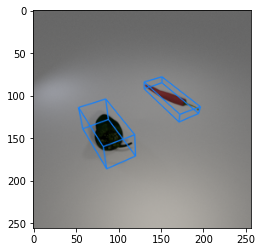

In [ ]:
plt.imshow(boxes_vis[0].permute(1,2,0))

In [ ]:
tids = torch.from_numpy(np.reshape(np.arange(hyp_B*hyp_N),[hyp_B,hyp_N]))
boxes_vis, corners_pix = summ_box_by_corners(rgb_camX1, gt_boxesX1_corners, torch.from_numpy(scores), tids, pix_T_cams[:, 1])

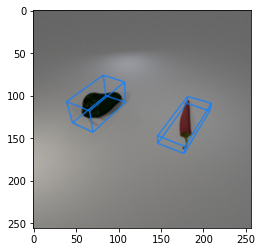

In [ ]:
plt.imshow(boxes_vis[0].permute(1,2,0))

In [ ]:
print(corners_pix)
print(corners_pix.shape)

tensor([[[[119.4490, 146.0197],
          [ 82.2279, 160.6942],
          [120.1407, 171.5554],
          [ 86.1270, 186.3349],
          [ 85.9574, 104.1768],
          [ 53.5821, 114.3011],
          [ 88.8343, 128.6410],
          [ 58.9012, 139.1309]],

         [[196.5392, 113.5040],
          [172.6527, 122.8315],
          [194.8824, 121.9209],
          [171.5288, 131.3607],
          [151.5566,  78.0333],
          [130.0628,  84.5563],
          [151.0769,  85.8458],
          [130.0193,  92.5010]]]], device='cuda:0')
torch.Size([1, 2, 8, 2])


In [ ]:
def draw_bounding_box(image, bboxes):
    
    num_obj= hyp_N #bboxes.size(0)
    fig = plt.figure(figsize=(8,8*num_obj))
    
    axes = []
    for o in range(num_obj):
        ax = (fig.add_subplot(1,num_obj,o+1))
        axes.append(ax)
        box = bboxes[o]
        x1,y1,x2,y2 = box
        x1 = int(x1.item()); x2 = int(x2.item()); y1 = int(y1.item()); y2 = int(y2.item())
        ax.title.set_text("x1:{} , x2:{} , y1:{} , y2:{}".format(x1,x2,y1,y2))
        img = cv2.rectangle(image.copy(),(x1,y1),(x2,y2),(0,255,0),2)
        plt.imshow(img)

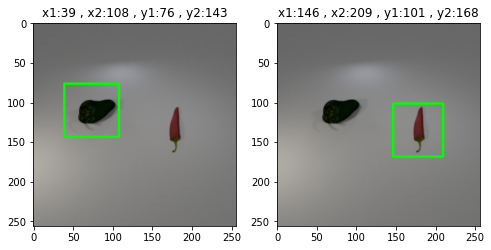

In [ ]:
for i in range(hyp_B):
    box = [[torch.min(corners_pix[i, n, :, 0]), torch.min(corners_pix[i, n, :, 1]), torch.max(corners_pix[i, n, :, 0]), torch.max(corners_pix[i, n, :, 1])] for n in range(hyp_N)]
    
    
    
    draw_bounding_box(rgb_camX1[0].permute(1,2,0).cpu().numpy(), box)
    plt.show()